In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import qnmfits
import analytic_fit
import utils
import corner

from cmcrameri import cm
from scipy.interpolate import CubicSpline

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)
t0_E = pd.read_csv('../data/t0N_E.csv', index_col=0)

In [3]:
N = 12
modes = [(2, 2, n, 1) for n in range(N+1)]

injection_info, C, omega = utils.injection(
    ID = 1,
    N = N,
    tref=t0_M['1'].values[N],
    returnC=True
)
sim = injection_info['sim']

In [4]:
injection_info_with_320, C_with_320, omega_with_320 = utils.injection(
    ID = 1,
    N = N,
    additional_modes=[(3,2,0,1)],
    tref=t0_M['1'].values[N],
    returnC=True
)
sim_with_320 = injection_info_with_320['sim']

In [5]:
data = {
    'plus': np.real(sim.h[2,2]),
    'cross': -np.imag(sim.h[2,2]),
}

In [6]:
A220_with_320 = np.abs(C_with_320)[0]
A220 = np.abs(C)[0]
A320 = np.abs(C_with_320)[-1]

In [7]:
A220, A220_with_320, A320

(np.float64(1.5798345203686586),
 np.float64(1.580124532340711),
 np.float64(0.0031918975422878166))

In [8]:
omega_220 = omega[0]
tau_220 = -1/np.imag(omega_220)
A220_of_t = A220 * np.exp(-(sim.times-t0_M['1'].values[N])/tau_220)

omega_320 = omega_with_320[-1]
tau_320 = -1/np.imag(omega_320)
A320_of_t = A320 * np.exp(-(sim_with_320.times-t0_M['1'].values[N])/tau_320)

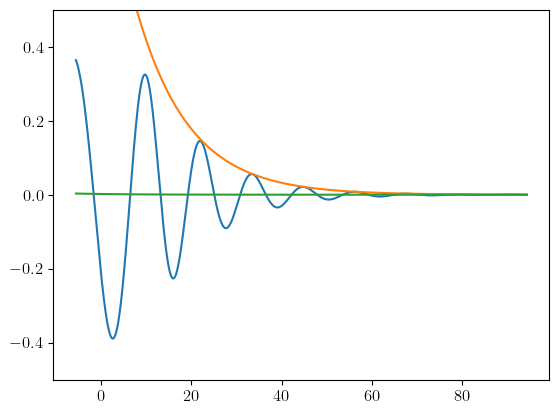

In [9]:
fig, ax = plt.subplots()
# ax.set_yscale('log')

ax.plot(sim.times, np.real(sim.h[2,2]))
ax.plot(sim.times, A220_of_t)
ax.plot(sim.times, A320_of_t)

ax.set_ylim(-0.5, 0.5);

In [10]:
samples, A_samples, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data,
    # sigma=A320_of_t,
    sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0_M['1'].values[N],
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
)

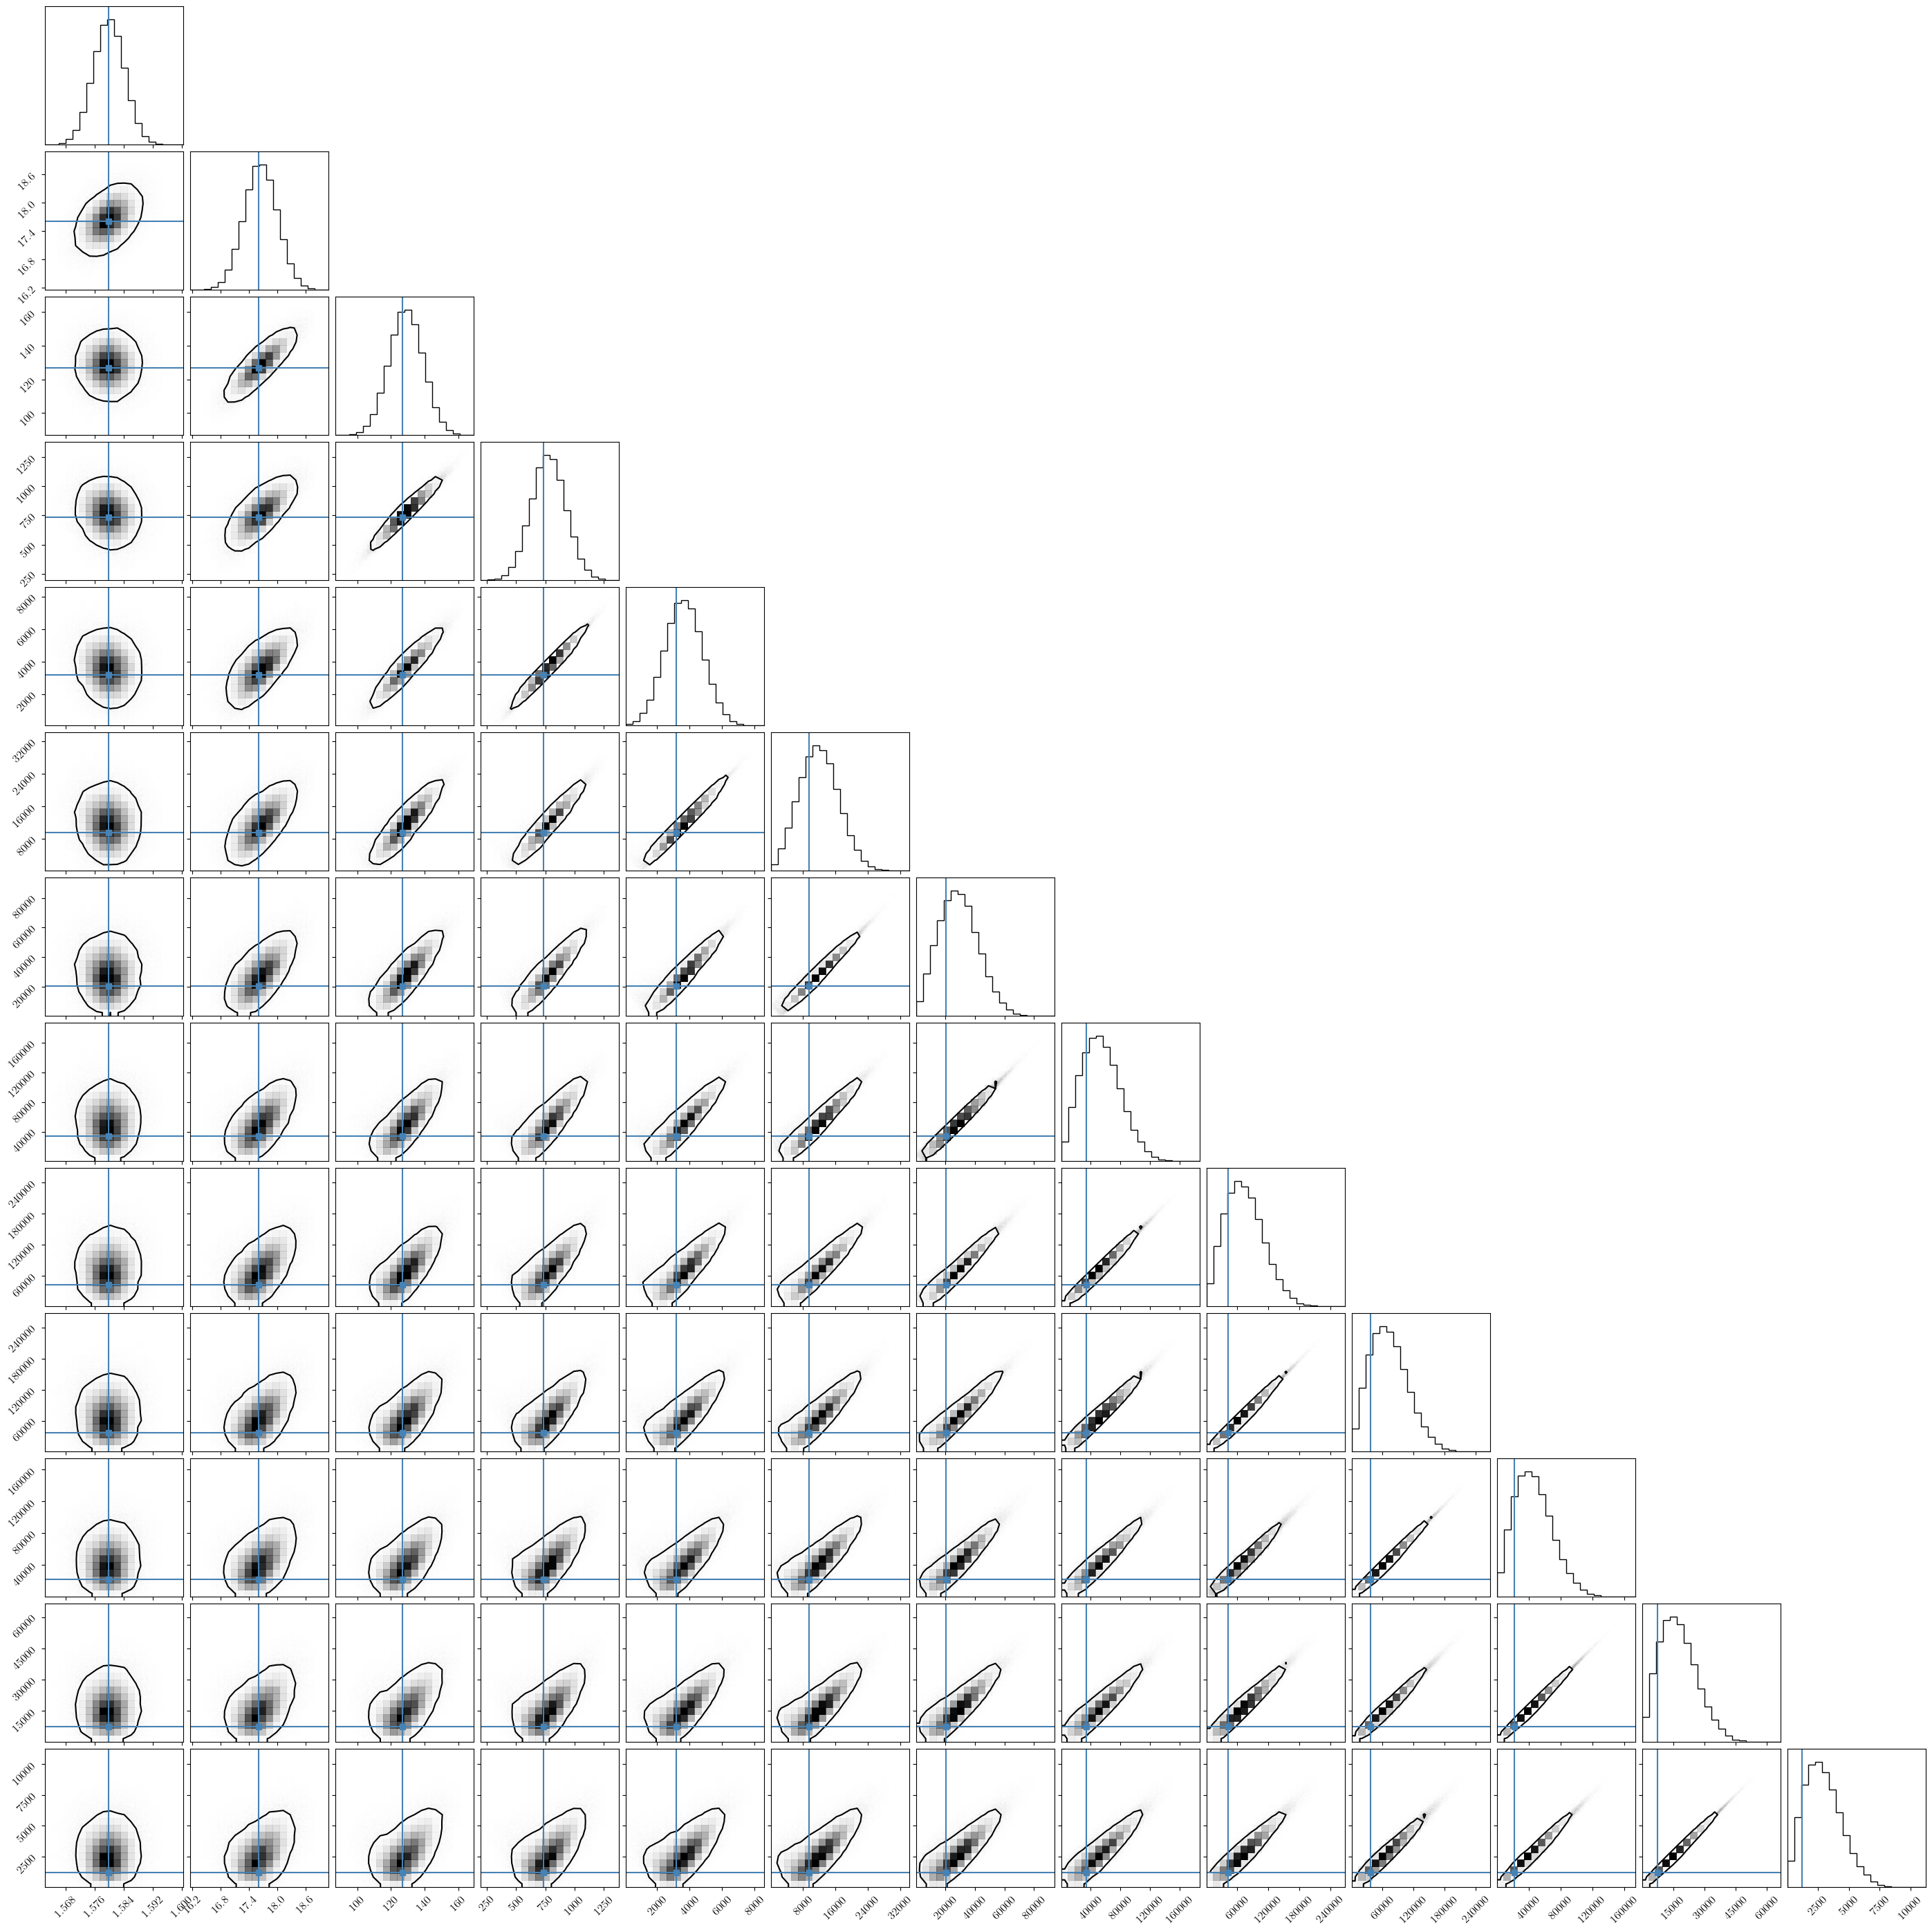

In [11]:
corner.corner(
    A_samples,
    truths=list(np.abs(C)),
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

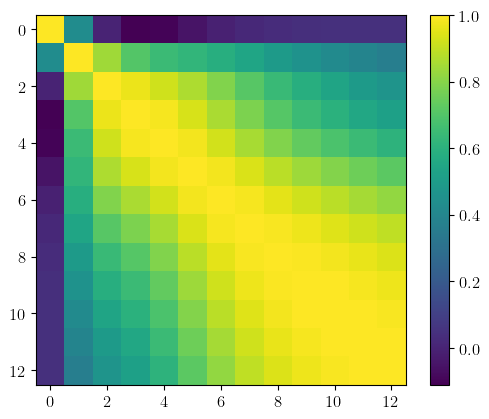

In [12]:
corr_matrix = np.corrcoef(A_samples.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

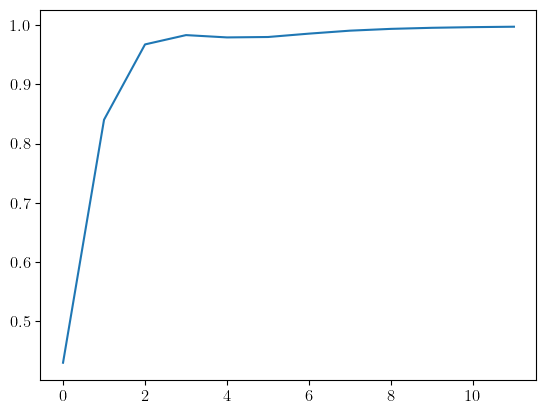

In [13]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)
plt.plot(corrs)

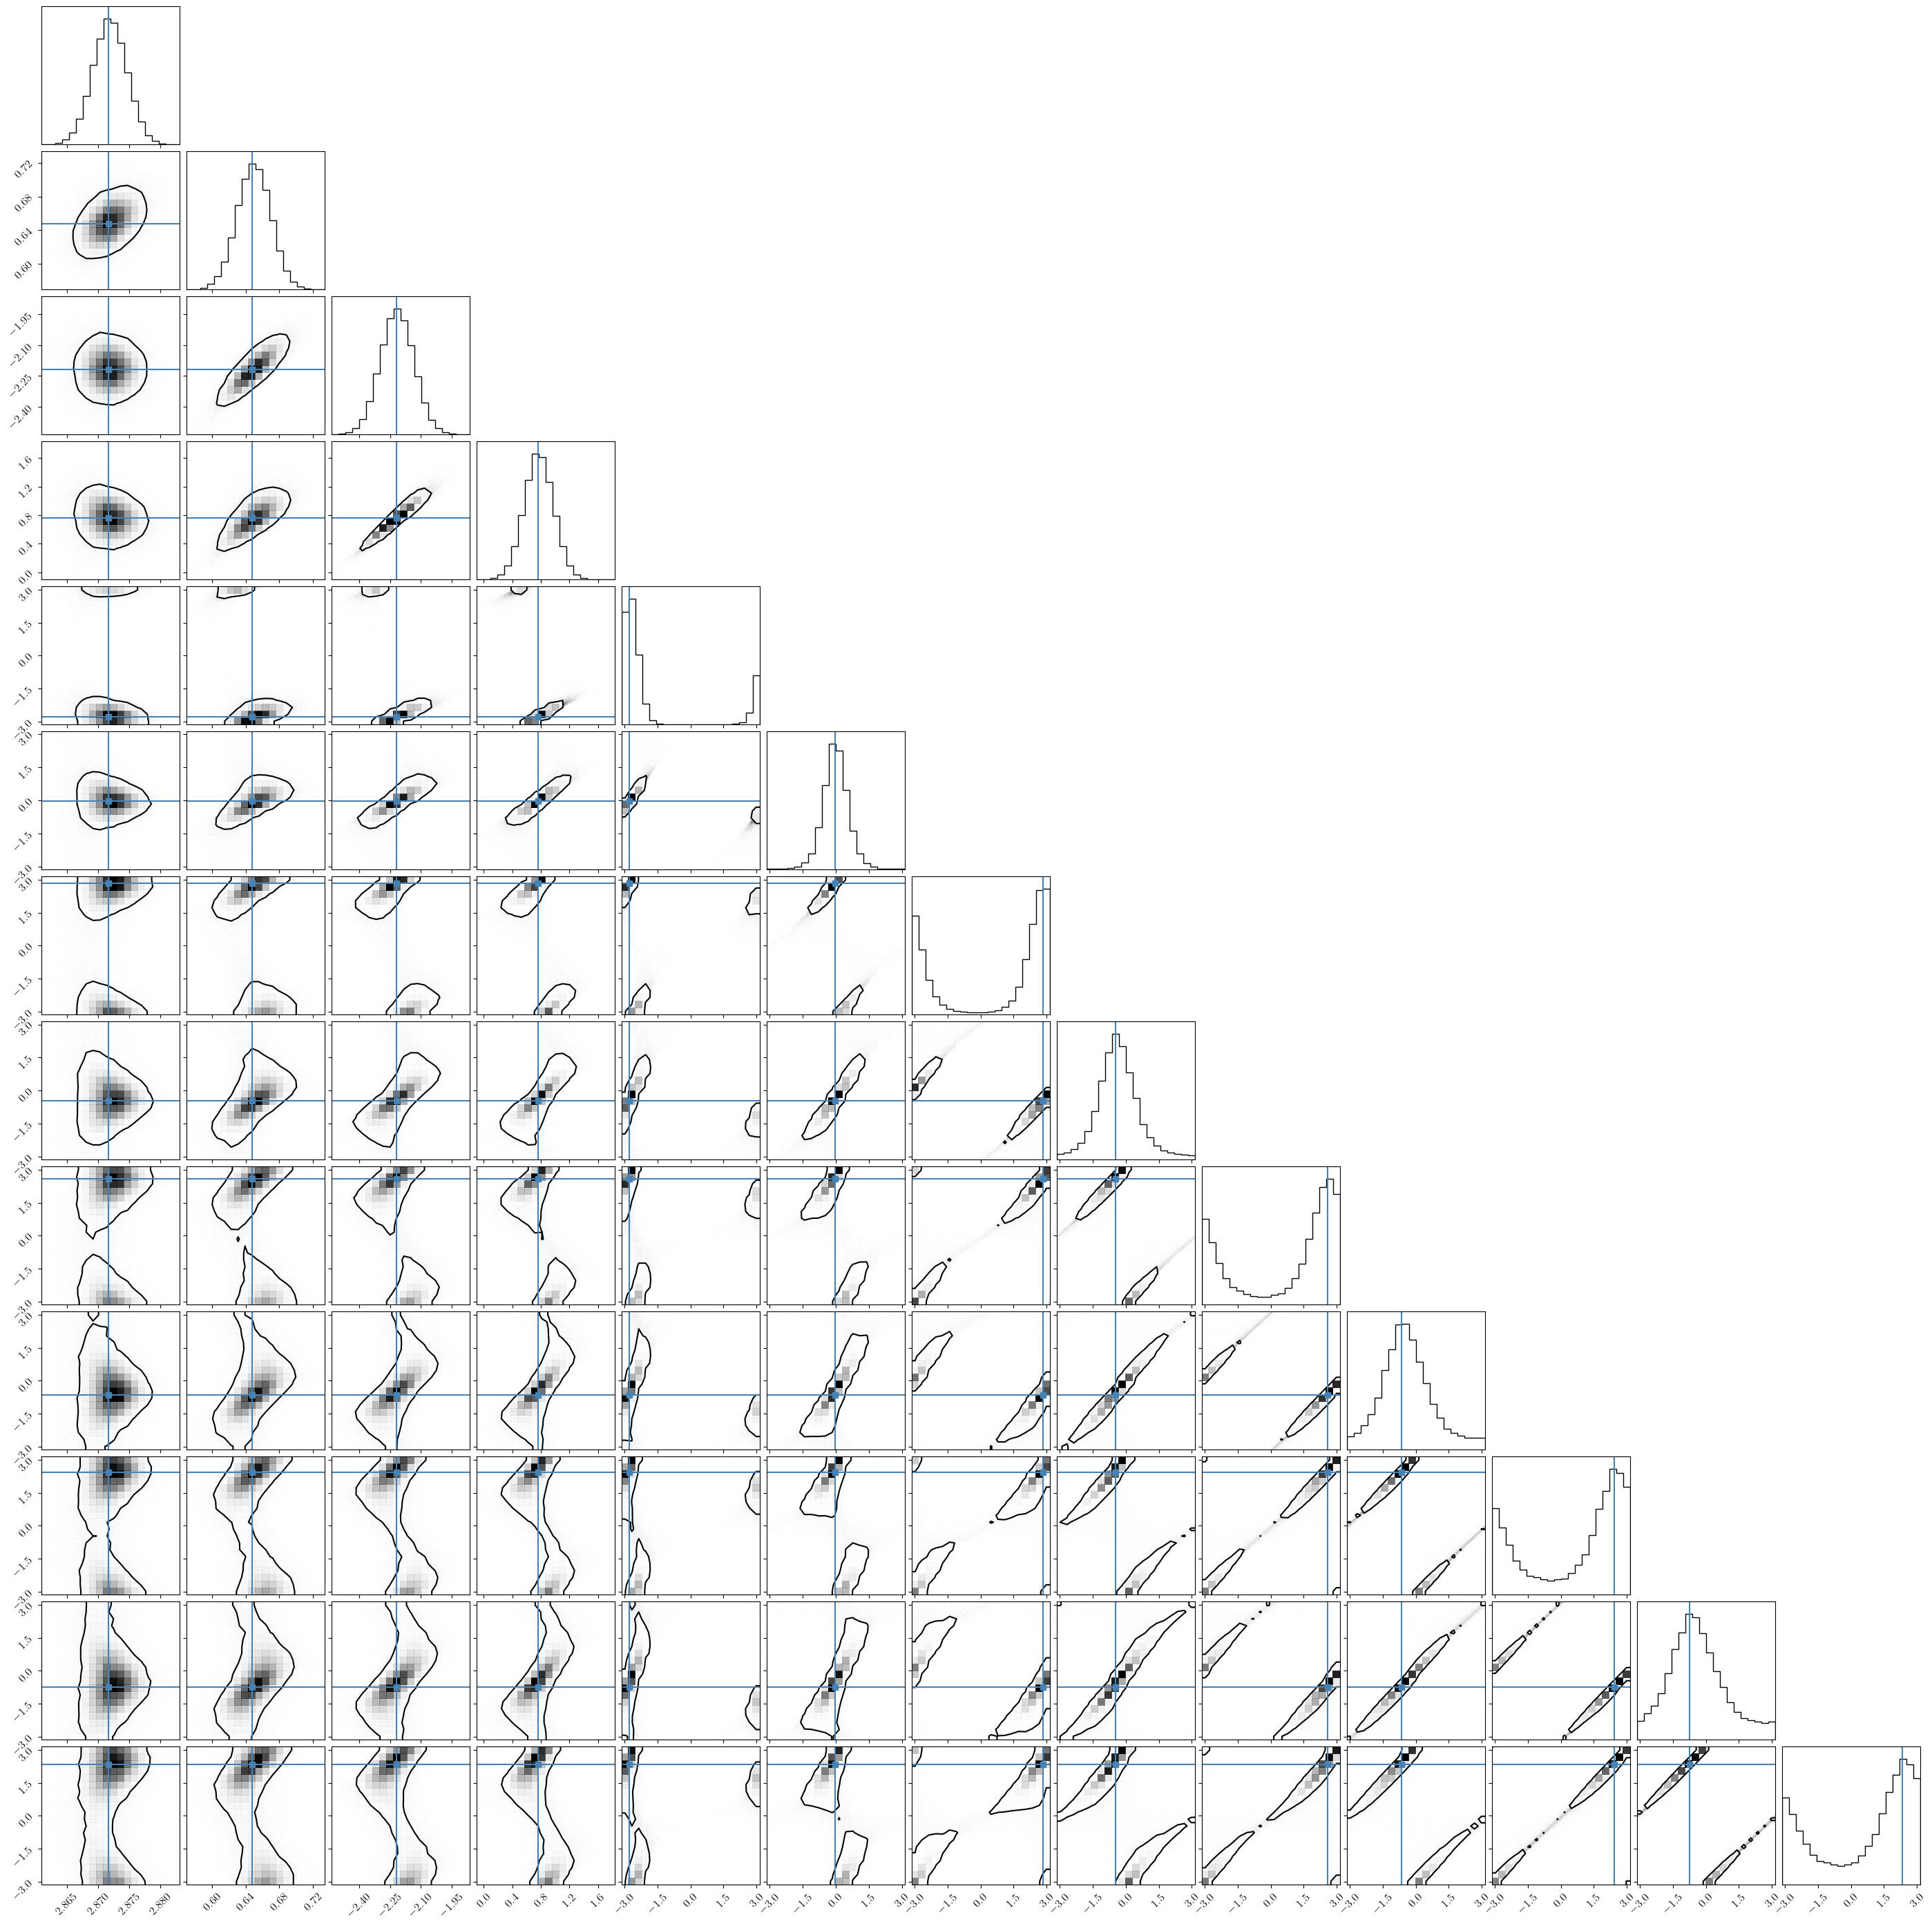

In [14]:
corner.corner(
    phi_samples,
    truths=list(np.angle(C)),
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

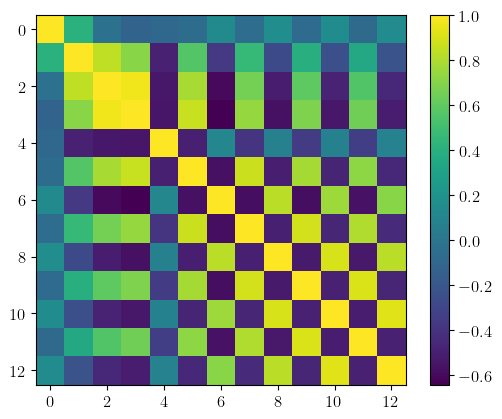

In [15]:
corr_matrix = np.corrcoef(phi_samples.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

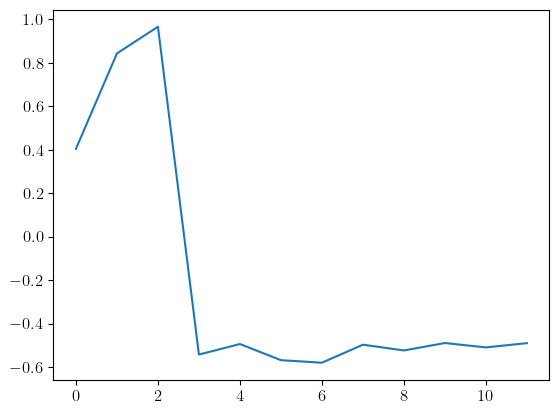

In [16]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)
plt.plot(corrs)

In [17]:
data_with_320 = {
    'plus': np.real(sim_with_320.h[2,2]),
    'cross': -np.imag(sim_with_320.h[2,2]),
}

In [18]:
samples, A_samples_with_320, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data_with_320,
    # sigma=5*A320_of_t,
    sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0_M['1'].values[N],
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
)

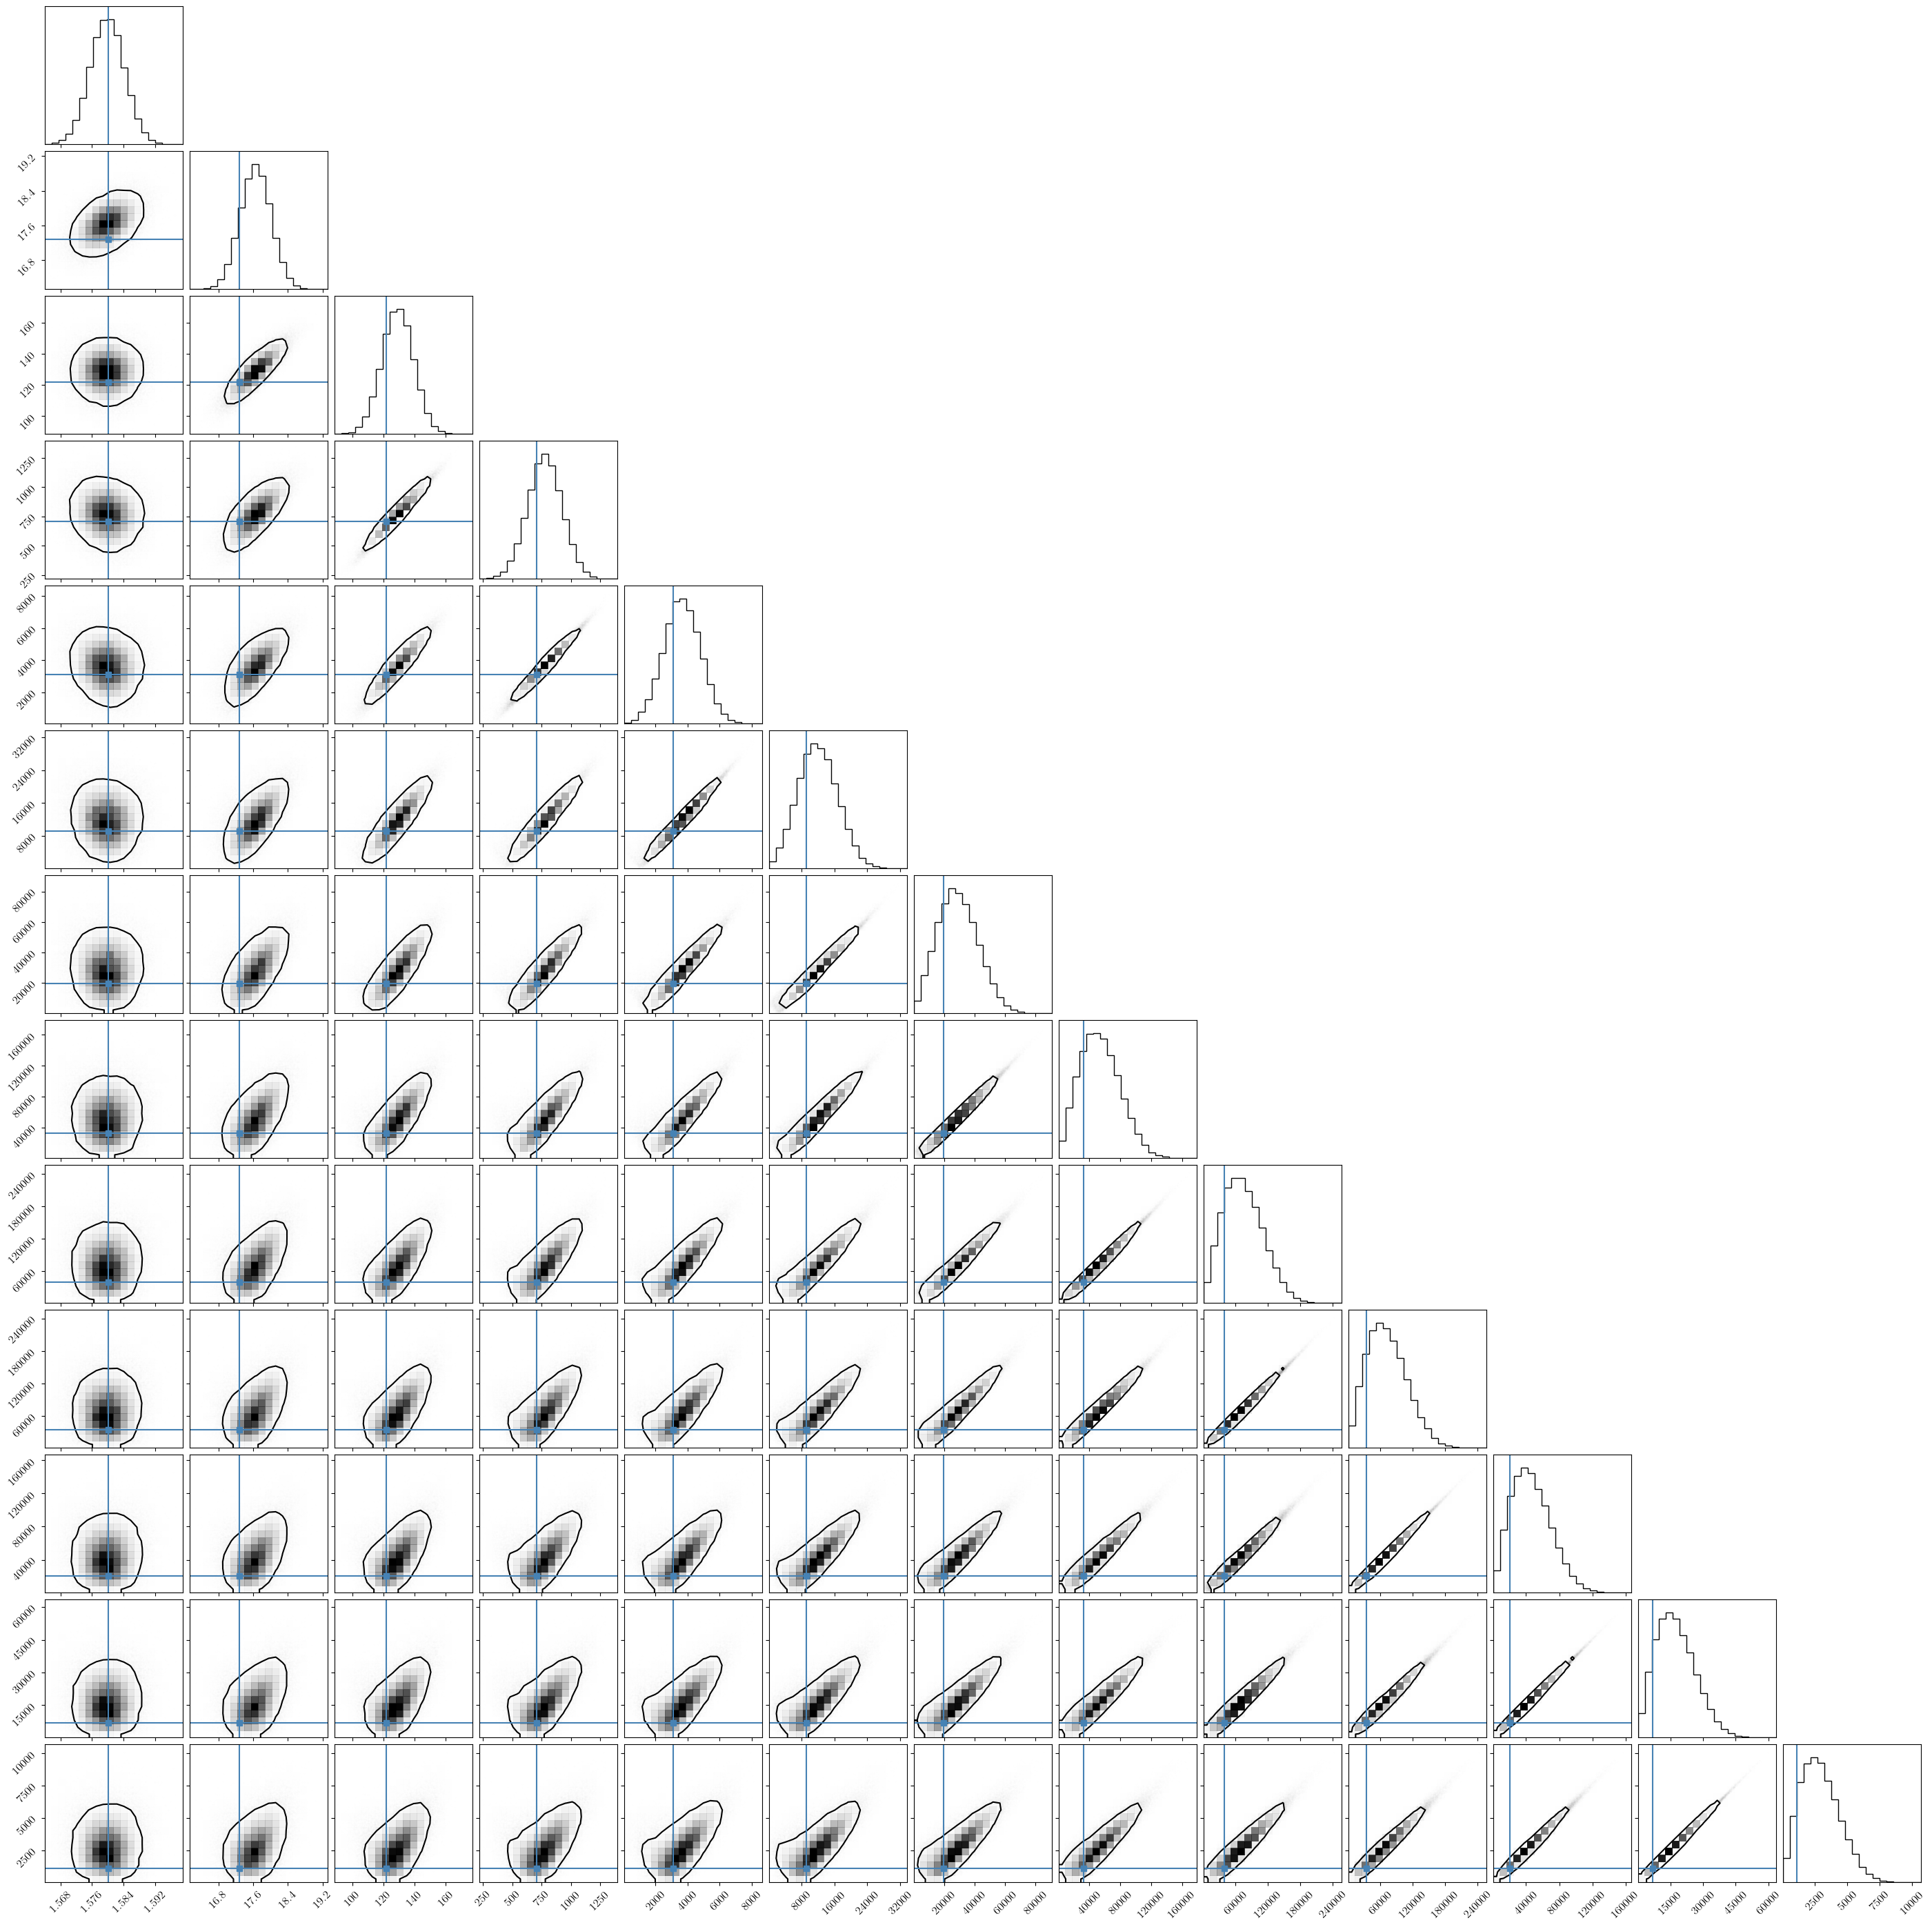

In [19]:
corner.corner(
    A_samples_with_320,
    truths=list(np.abs(C_with_320))[:-1],
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

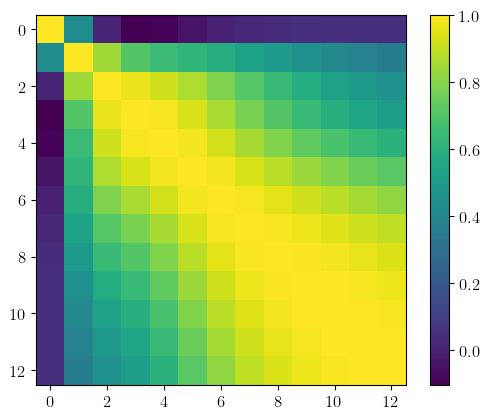

In [20]:
corr_matrix = np.corrcoef(A_samples_with_320.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

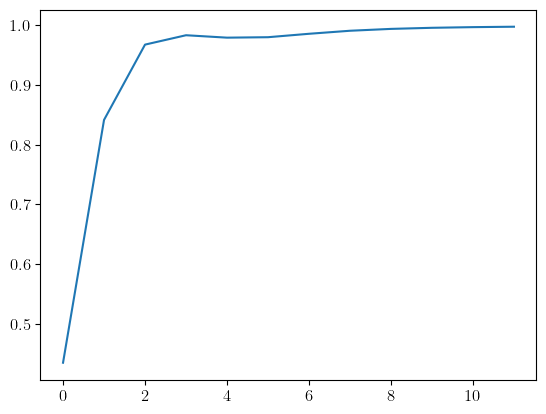

In [21]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)
plt.plot(corrs)

In [22]:
sim_info = utils.load_cce_data(1)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

In [23]:
N = 12
t0 = t0_M['1'].values[N]
modes = [(2, 2, n, 1) for n in range(N+1)] + [(3,2,0,1)]

In [24]:
t0

np.float64(-5.546189489295102)

In [25]:
best_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest'
)

In [26]:
best_fit_without_320 = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=[(2, 2, n, 1) for n in range(N+1)],
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest'
)

In [27]:
data = {
    'plus': np.real(sim.h[2,2]),
    'cross': -np.imag(sim.h[2,2]),
}

In [28]:
A320 = np.abs(best_fit['C'])[-1]
omega = best_fit['frequencies'][:-1]

In [29]:
samples, A_samples, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data,
    # sigma=A320_of_t,
    sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0,
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
)

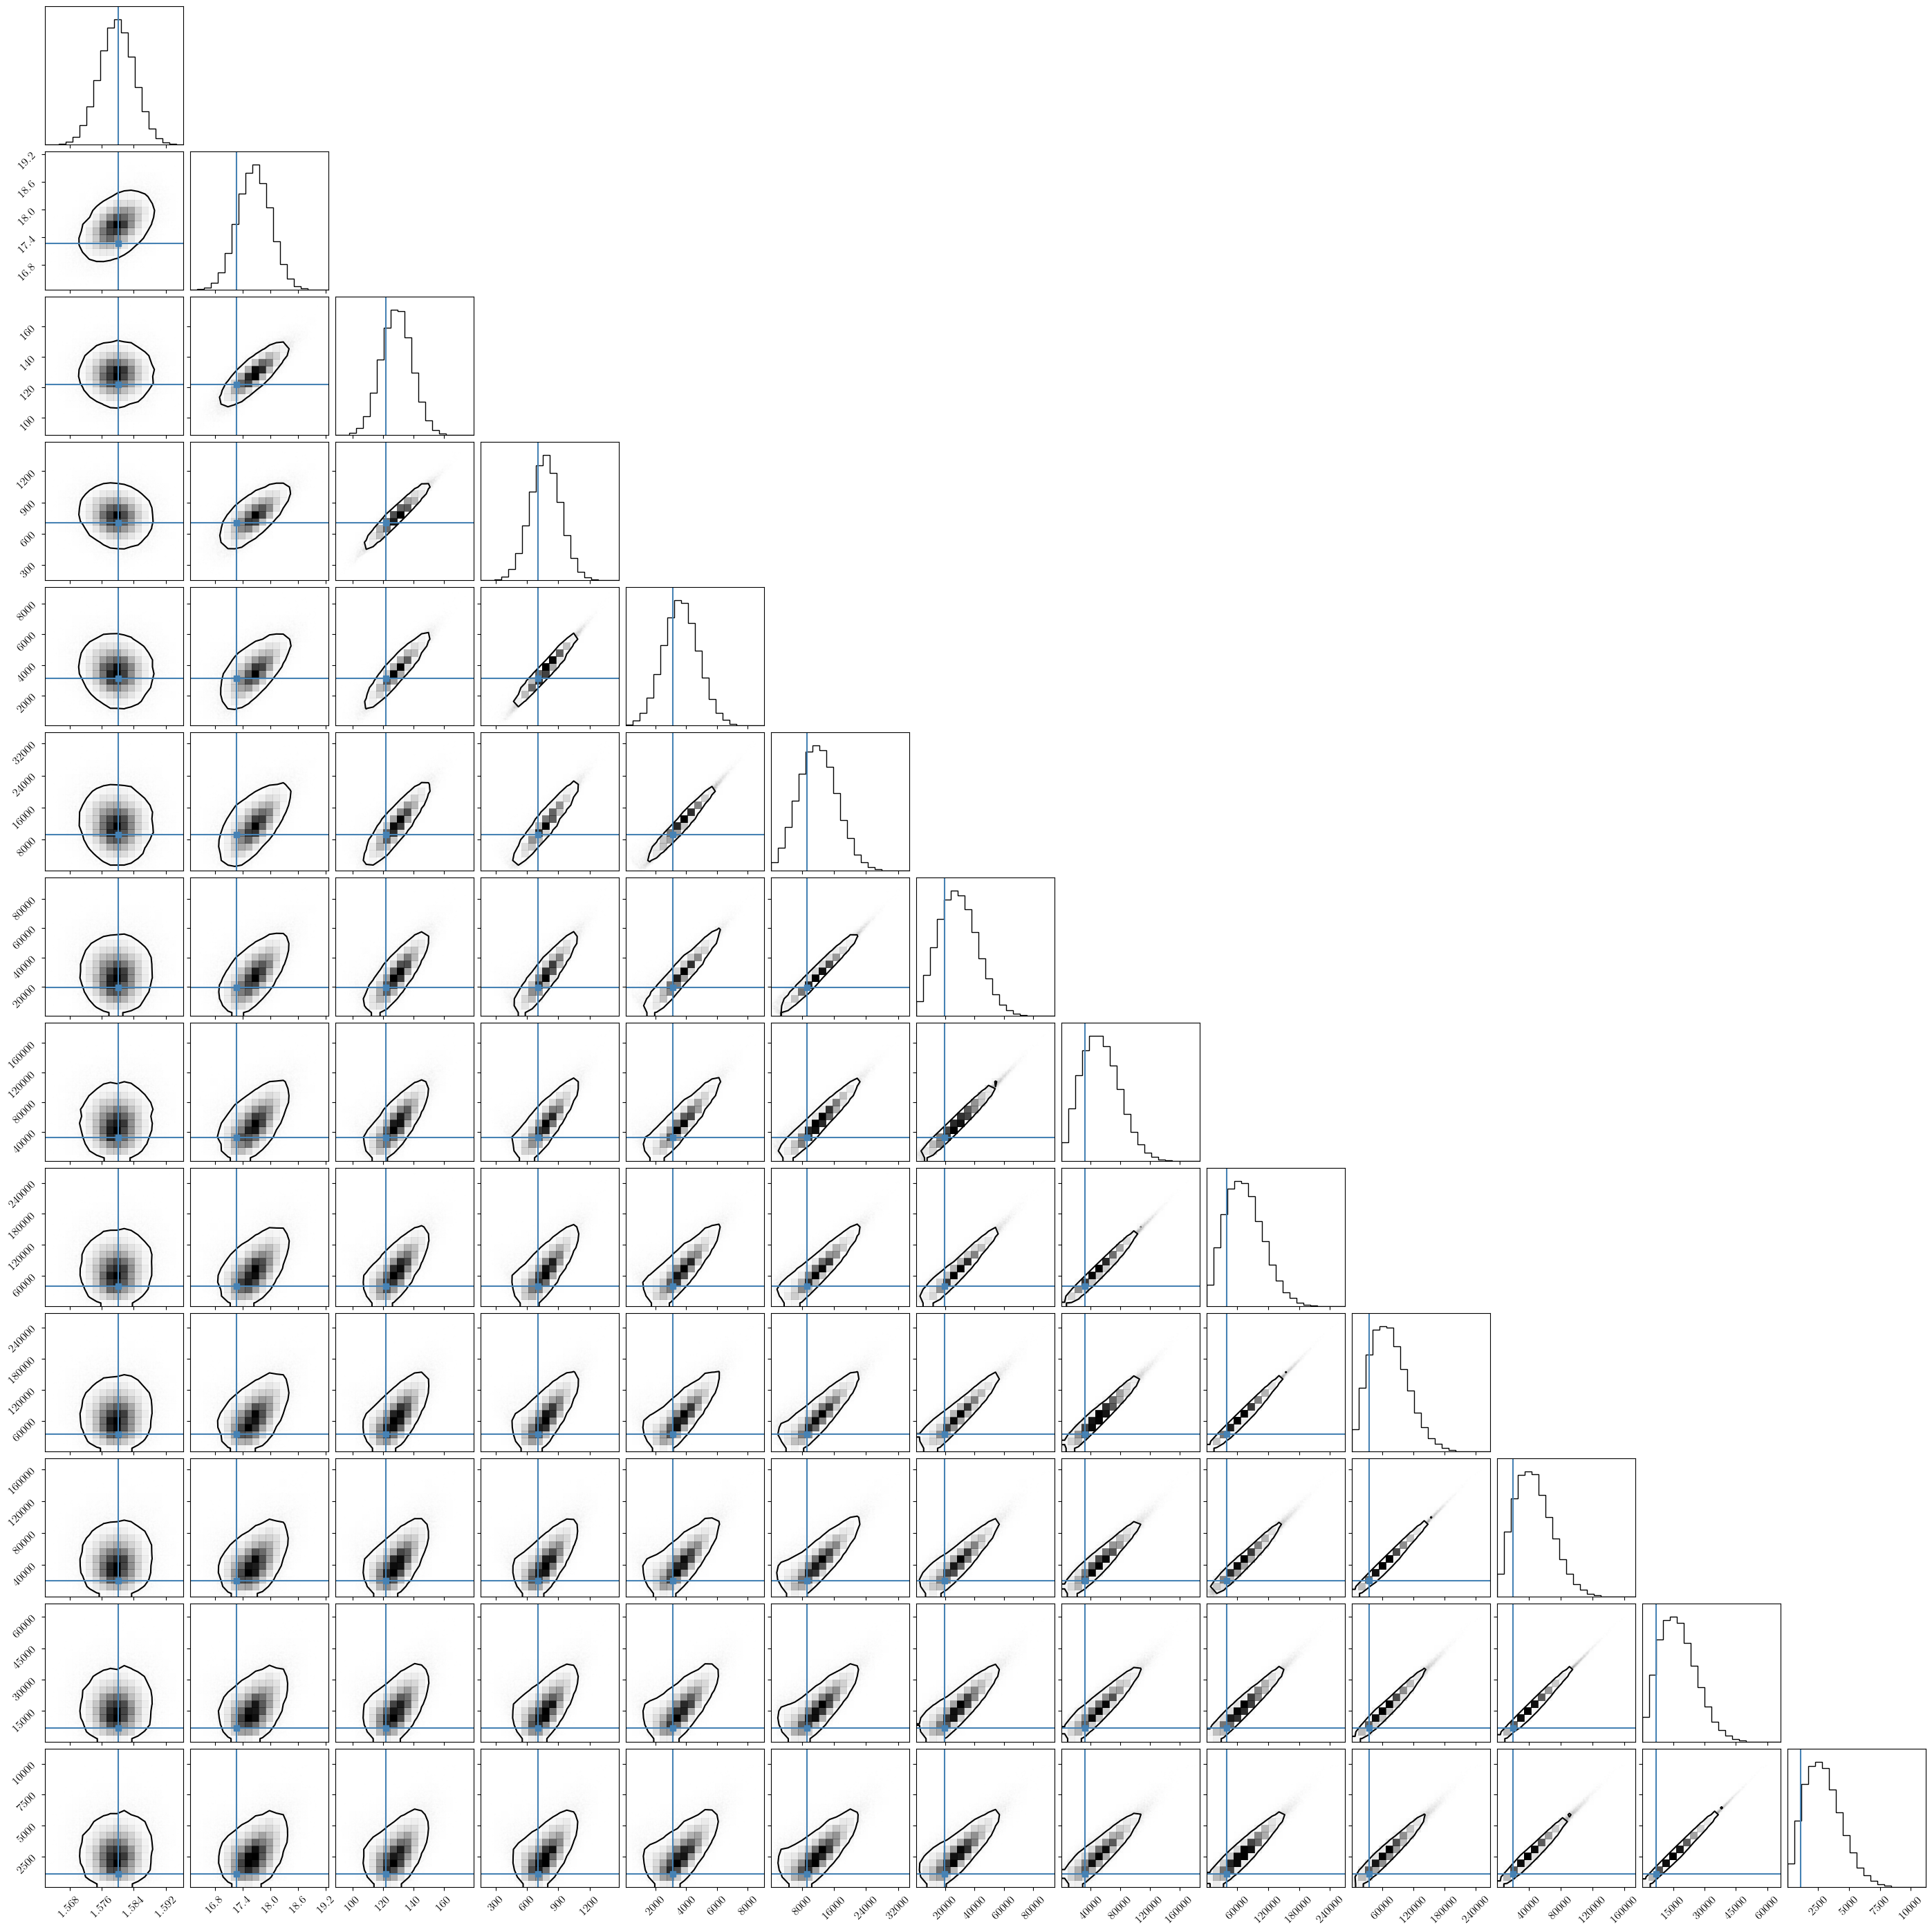

In [30]:
corner.corner(
    A_samples,
    truths=list(np.abs(best_fit['C']))[:-1],
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

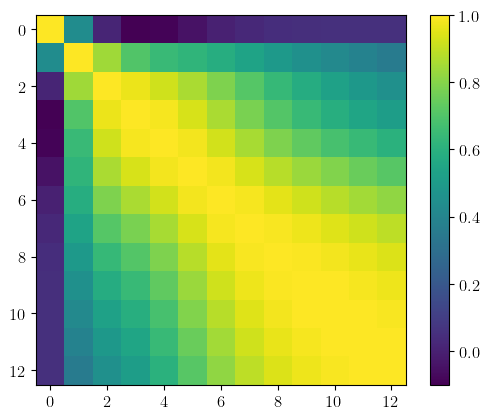

In [31]:
corr_matrix = np.corrcoef(A_samples.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

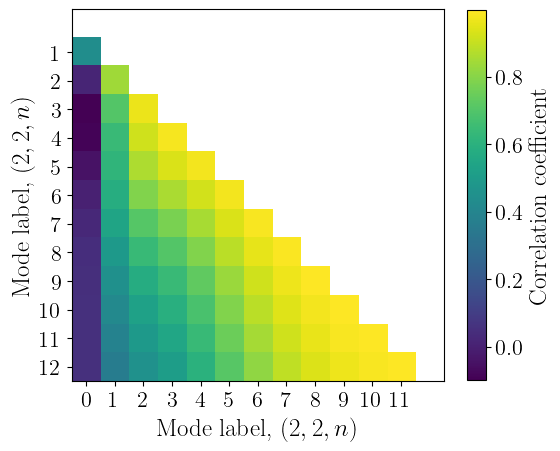

In [32]:
fig, ax = plt.subplots(figsize=(6,6))

masked_matrix = np.ma.masked_array(
    corr_matrix, mask=np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
)

im = ax.imshow(masked_matrix, cmap='viridis')
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Correlation coefficient', fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.tick_params(axis='x', labelsize=16)

ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.tick_params(axis='y', labelsize=16)

ax.set_xlabel('Mode label, $(2,2,n)$', fontsize=18)
ax.set_ylabel('Mode label, $(2,2,n)$', fontsize=18)

fig.savefig('figures/presentation/correlation_matrix.png', dpi=300, bbox_inches='tight')

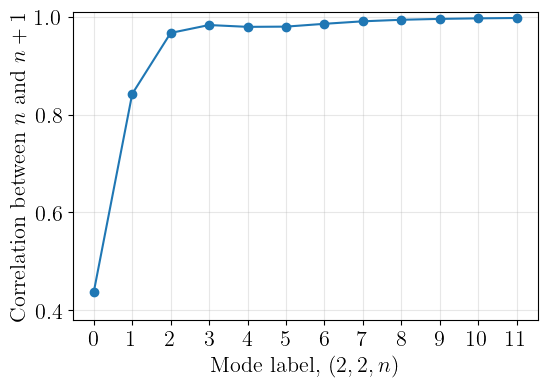

In [33]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)

fig, ax = plt.subplots(figsize=(6, 4))

ax.grid(alpha=0.3)

ax.plot(corrs, marker='o', linestyle='-', color='C0')

ax.set_xticks(range(len(corrs)))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylim(0.38, 1.01)

ax.set_xlabel('Mode label, $(2,2,n)$', fontsize=16)
ax.set_ylabel('Correlation between $n$ and $n+1$', fontsize=16)

fig.savefig('figures/presentation/correlation_diagonal.png', dpi=300, bbox_inches='tight')

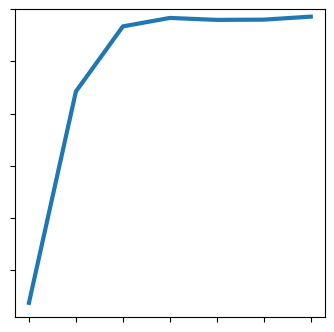

In [34]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)

fig, ax = plt.subplots(figsize=(4, 4))

# ax.grid(alpha=0.3)

ax.plot(corrs[:7], color='C0', lw=3)
# ax.plot(corrs, marker='o', lw=0, color='C0')

# ax.set_xticks(range(len(corrs)))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylim(ax.get_ylim()[0], 1.)

# ax.set_xlabel('Mode label, $(2,2,n)$', fontsize=16)
# ax.set_ylabel('Correlation between $n$ and $n+1$', fontsize=16)

ax.set_xticks(np.arange(0, 7))

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.savefig('figures/presentation/correlation_diagonal_overview.png', dpi=300, bbox_inches='tight')

In [35]:
from matplotlib import colormaps
cmap = colormaps['Blues']

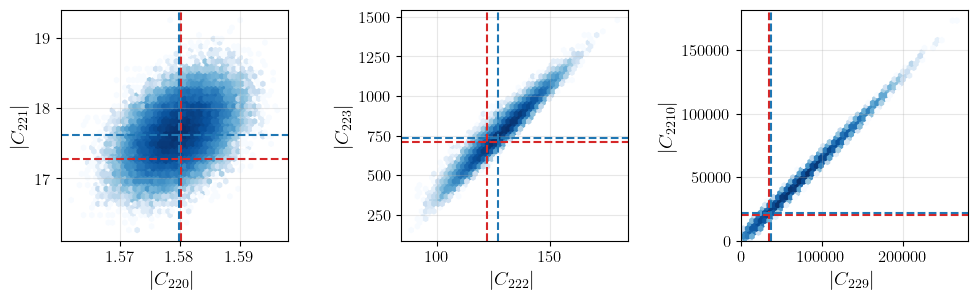

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(11.7, 3))

fig.subplots_adjust(wspace=0.5)

for ax in axs:
    ax.grid(alpha=0.3)

for i, (ni, nj) in enumerate([(0, 1), (2, 3), (9, 10)]):

    x = A_samples[:, ni]
    y = A_samples[:, nj]

    ax = axs[i]
    hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

    ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
    ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

    ax.axvline(np.abs(best_fit_without_320['C'][ni]), color='C0', linestyle='--')
    ax.axhline(np.abs(best_fit_without_320['C'][nj]), color='C0', linestyle='--')

    ax.set_xlabel(f'$|C_{{22{ni}}}|$')
    ax.set_ylabel(f'$|C_{{22{nj}}}|$')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if xlim[0] < 0:
        ax.set_xlim(0, xlim[1])
    if ylim[0] < 0:
        ax.set_ylim(0, ylim[1])

# fig.savefig('figures/presentation/correlation_row.png', dpi=300, bbox_inches='tight')

In [37]:
ni = 0
nj = 1

x = A_samples[:, ni]
y = A_samples[:, nj]



hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

fig.savefig('figures/presentation/correlation_0.png', dpi=300, bbox_inches='tight')

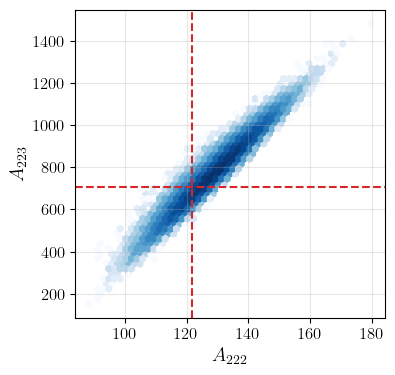

In [38]:
ni = 2
nj = 3

x = A_samples[:, ni]
y = A_samples[:, nj]

fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(alpha=0.3)

hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

fig.savefig('figures/presentation/correlation_1.png', dpi=300, bbox_inches='tight')

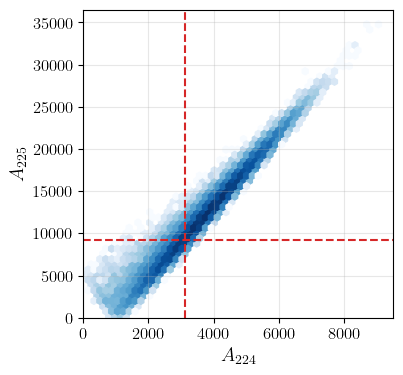

In [39]:
ni = 4
nj = 5

x = A_samples[:, ni]
y = A_samples[:, nj]

fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(alpha=0.3)

hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

ax.set_xlim(0)
ax.set_ylim(0)

fig.savefig('figures/presentation/correlation_2.png', dpi=300, bbox_inches='tight')

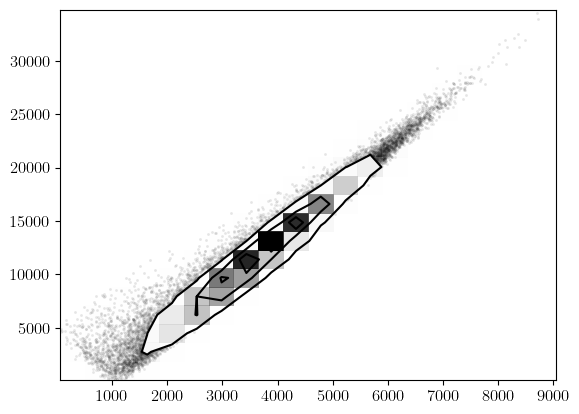

In [40]:
corner.hist2d(x, y)

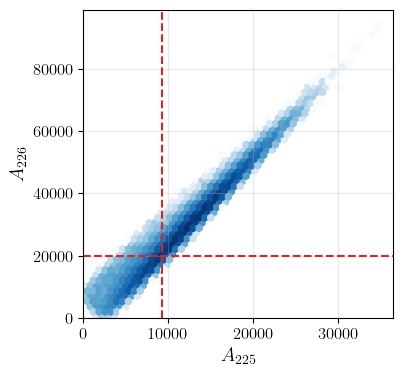

In [41]:
ni = 5
nj = 6

x = A_samples[:, ni]
y = A_samples[:, nj]

fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(alpha=0.3)

hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

ax.set_xlim(0)
ax.set_ylim(0)

fig.savefig('figures/presentation/correlation_3.png', dpi=300, bbox_inches='tight')